In [15]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X = X.to_numpy()

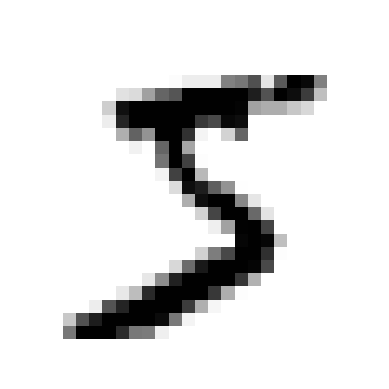

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:6000], X[6000:], y[:6000], y[6000:]

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [8]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9615
0.962
0.963


In [9]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.962 , 0.956 , 0.9665])

In [10]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [11]:
con_matrix = confusion_matrix(y_train_5, y_train_pred)

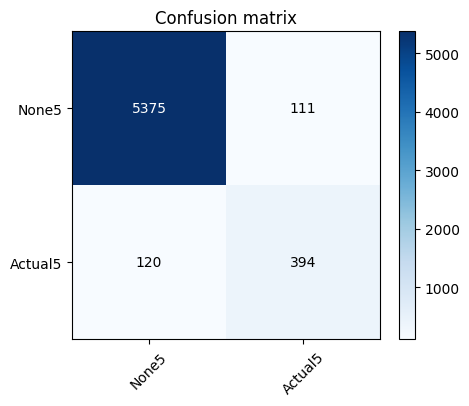

In [12]:
plt.figure(figsize=(5, 4))
cmap = plt.get_cmap('Blues')
plt.imshow(con_matrix, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
targets = np.array(['None5', 'Actual5'])
targets_pos = np.arange(len(targets))
plt.xticks(targets_pos, targets, rotation=45)
plt.yticks(targets_pos, targets)
thresh = con_matrix.max() / 2 #Umbral entre blanco y negro
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        plt.text(j , i, format(con_matrix[i, j], 'd'),
        ha='center', va='center', 
        color='white' if con_matrix[i, j] > thresh else 'black')

In [13]:
print(precision_score(y_train_5, y_train_pred))
#Precision score : Falsos positivos costosos
print(recall_score(y_train_5, y_train_pred))
#Recall score : Falsos negativos costosos

0.7801980198019802
0.7665369649805448


In [16]:
f1_score(y_train_5, y_train_pred)

0.7733071638861629